<a href="https://colab.research.google.com/github/DomBBB/MLHSG/blob/main/EuroSAT_Pix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EuroSAT Challenge: Model

Uses a Google Colab (T4 GPU) Runtime with extended RAM!

## Mount the drive to store data permanently

In [1]:
from google.colab import drive
import os

drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/MLHSG/")

Mounted at /content/drive


## Load data into current runtime

In [2]:
if not os.path.exists(os.path.expanduser("~/trainingdataMS")):
    os.makedirs(os.path.expanduser("~/trainingdataMS"))
    !cp dataMS/EuroSAT_MS.zip ~/trainingdataMS/EuroSAT_MS.zip
    !unzip -q ~/trainingdataMS/EuroSAT_MS.zip -d ~/trainingdataMS
print("Data loaded locally.")

Data loaded locally.


In [15]:
if not os.path.exists(os.path.expanduser("~/aiml-coding-challenge-fs24.zip")):
    !cp test/aiml-coding-challenge-fs24.zip ~/aiml-coding-challenge-fs24.zip
    !unzip -q ~/aiml-coding-challenge-fs24.zip -d ~/
    !mv ~/train.csv ~/trainingdataMS/EuroSAT_MS/train.csv
    !rm ~/sample_submission.csv
    !rm ~/test.csv
print("Data loaded locally.")

mv: cannot move '/root/train.csv' to '/root/trainingdataMS/EuroSAT_MS/train.csv': No such file or directory
Data loaded locally.


In [ ]:
if not os.path.exists(os.path.expanduser("~/dataMajTOM")):
    os.makedirs(os.path.expanduser("~/dataMajTOM"))
    os.makedirs(os.path.expanduser("~/dataMajTOM/train"))
    os.makedirs(os.path.expanduser("~/dataMajTOM/train_full"))
    os.makedirs(os.path.expanduser("~/dataMajTOM/test"))
    for zip_file in sorted(os.listdir("dataMajTOM")):
      print(f"Extracting {zip_file}")
      if zip_file.startswith("MajTOM_train"):
        !mkdir -p ~/temp_extract
        !cp dataMajTOM/{zip_file} ~/temp_extract/{zip_file}
        !unzip -q ~/temp_extract/{zip_file} -d ~/temp_extract
        # need to handle> /usr/bin/mv: Argument list too long
        !find ~/temp_extract/root/MajTOM/train/ -type f -exec mv {} ~/dataMajTOM/train_full/ \;
        !rm -r ~/temp_extract
      elif zip_file.startswith("MajTOM_test"):
        !mkdir -p ~/temp_extract
        !cp dataMajTOM/{zip_file} ~/temp_extract/{zip_file}
        !unzip -q ~/temp_extract/{zip_file} -d ~/temp_extract
        !mv ~/temp_extract/root/MajTOM/test/* ~/dataMajTOM/test
        !rm -r ~/temp_extract
      else:
        raise Error

print("Data loaded locally.")

Extracting MajTOM_test_0.zip
Extracting MajTOM_test_1.zip
Extracting MajTOM_test_2.zip
Extracting MajTOM_test_3.zip
Extracting MajTOM_test_4.zip
Extracting MajTOM_test_5.zip
Extracting MajTOM_test_6.zip
Extracting MajTOM_test_7.zip
Extracting MajTOM_train_0.zip
Extracting MajTOM_train_1.zip
Extracting MajTOM_train_2.zip
Extracting MajTOM_train_3.zip
Extracting MajTOM_train_4.zip
Extracting MajTOM_train_5.zip
Extracting MajTOM_train_6.zip
Extracting MajTOM_train_7.zip
Data loaded locally.


In [ ]:
if not os.path.exists(os.path.expanduser("~/dataAB")):
    os.makedirs(os.path.expanduser("~/dataAB"))
    os.makedirs(os.path.expanduser("~/dataAB/train_transformed/test"))
    os.makedirs(os.path.expanduser("~/dataAB/test_transformed/test"))

    !mkdir -p ~/temp_extract
    !cp dataAB/DataAB_train.zip ~/temp_extract/DataAB_train.zip
    !unzip -q ~/temp_extract/DataAB_train.zip -d ~/temp_extract
    !mv ~/temp_extract/root/dataAB/train_transformed/* ~/dataAB/train_transformed/test
    !rm -r ~/temp_extract

    !mkdir -p ~/temp_extract
    !cp dataAB/DataAB_test.zip ~/temp_extract/DataAB_test.zip
    !unzip -q ~/temp_extract/DataAB_test.zip -d ~/temp_extract
    !mv ~/temp_extract/root/dataAB/test_transformed/* ~/dataAB/test_transformed/test
    !rm -r ~/temp_extract

print("Data loaded locally.")

Data loaded locally.


How does an exemplary AB image look like?

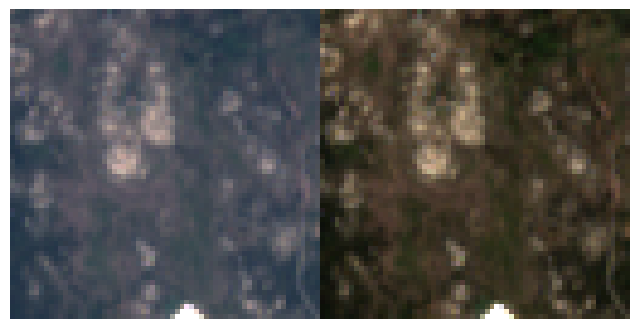

In [ ]:
import cv2
import matplotlib.pyplot as plt

example_image = os.path.join("~/dataMajTOM/train_full", sorted(os.listdir(os.path.expanduser("~/dataMajTOM/train_full")))[100])
img_AB = cv2.imread(os.path.expanduser(example_image))

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_AB, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Pix2Pix

### Setup

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix ~/pytorch-CycleGAN-and-pix2pix

network_definitions = os.path.expanduser("~/pytorch-CycleGAN-and-pix2pix/models/networks.py")
with open(network_definitions, 'r') as file:
  lines = file.readlines()

new_block = "    elif netG == 'unet_64':\n        net = UnetGenerator(input_nc, output_nc, 6, ngf, norm_layer=norm_layer, use_dropout=use_dropout)\n"

for i, line in enumerate(lines):
  if "elif netG == 'unet_128':" in line:
    lines.insert(i, new_block)
    break

with open(network_definitions, 'w') as file:
  file.writelines(lines)

fatal: destination path '/root/pytorch-CycleGAN-and-pix2pix' already exists and is not an empty directory.


In [ ]:
!pip install -r ~/pytorch-CycleGAN-and-pix2pix/requirements.txt

### Train

In [ ]:
model_name_suffix = 3

model_name_suffix = "Pix2Pix_" + model_name_suffix
if not os.path.exists(os.path.expanduser(f"./models/Model_{model_name_suffix}")):
  os.makedirs(os.path.expanduser(f"./models/Model_{model_name_suffix}"))

Create a random data subset

In [ ]:
!ls ~/dataMajTOM/train_full | shuf -n 8000 | xargs -I {} cp ~/dataMajTOM/train_full/{} ~/dataMajTOM/train

In [ ]:
!python ~/pytorch-CycleGAN-and-pix2pix/train.py \
  --netG unet_64 --netD n_layers --n_layers_D 2 \
  --dataroot ~/dataMajTOM --name pix2pix_MajTOM \
  --model pix2pix --direction AtoB \
  --display_id -1 \
  --preprocess none \
  --n_epochs 10 --n_epochs_decay 10 \
  --checkpoints_dir models/Model_{model_name_suffix}/checkpoints

### Test

In [ ]:
!python ~/pytorch-CycleGAN-and-pix2pix/test.py \
  --netG unet_64 --netD n_layers --n_layers_D 2 \
  --dataroot ~/dataMajTOM --name pix2pix_MajTOM \
  --model pix2pix --direction AtoB \
  --preprocess none \
  --num_test 5000 \
  --checkpoints_dir models/Model_{model_name_suffix}/checkpoints \
  --results_dir ~/results/

In [ ]:
!zip -r ~/results.zip ~/results
!mv ~/results.zip ./models/Model_{model_name_suffix}/

Visualize an example:

In [ ]:
img_num = 599
example_image = os.path.join("~/results/pix2pix_MajTOM/test_latest/images/", sorted(os.listdir(os.path.expanduser("~/results/pix2pix_MajTOM/test_latest/images/")))[img_num])

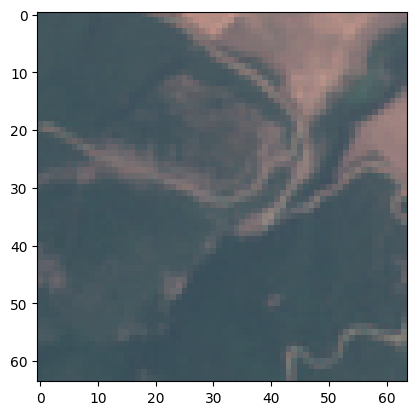

In [ ]:
img_path = example_image[:-10] + "real_A.png"
img = plt.imread(os.path.expanduser(img_path))
plt.imshow(img)

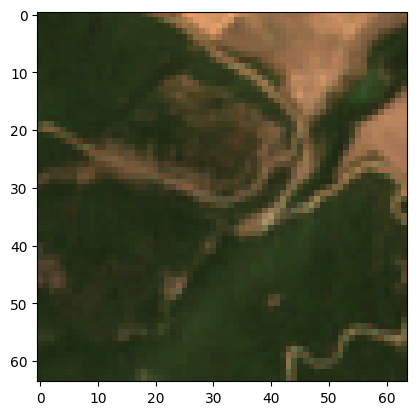

In [ ]:
img_path = example_image[:-10] + "real_B.png"
img = plt.imread(os.path.expanduser(img_path))
plt.imshow(img)

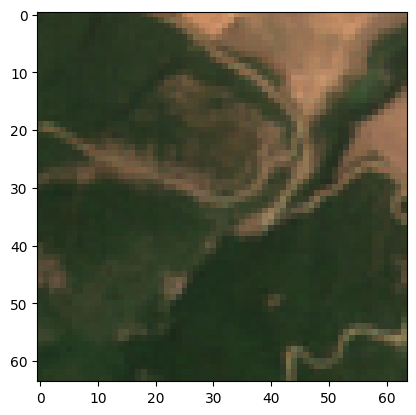

In [ ]:
img_path = example_image[:-10] + "fake_B.png"
img = plt.imread(os.path.expanduser(img_path))
plt.imshow(img)

### Transform our Training Images

In [ ]:
!python ~/pytorch-CycleGAN-and-pix2pix/test.py \
  --netG unet_64 --netD n_layers --n_layers_D 2 \
  --dataroot ~/dataAB/train_transformed --name pix2pix_MajTOM \
  --model pix2pix --direction AtoB \
  --preprocess none \
  --num_test {len(os.listdir(os.path.expanduser("~/dataAB/train_transformed/test")))} \
  --checkpoints_dir models/Model_{model_name_suffix}/checkpoints \
  --results_dir ~/train_rft/

In [ ]:
!zip -r ~/train_rft.zip ~/train_rft
!mv ~/train_rft.zip ./models/Model_{model_name_suffix}/

Visualize an example:

In [ ]:
img_num = 599
example_image = os.path.join("~/train_rft/pix2pix_MajTOM/test_latest/images/", sorted(os.listdir(os.path.expanduser("~/train_rft/pix2pix_MajTOM/test_latest/images/")))[img_num])

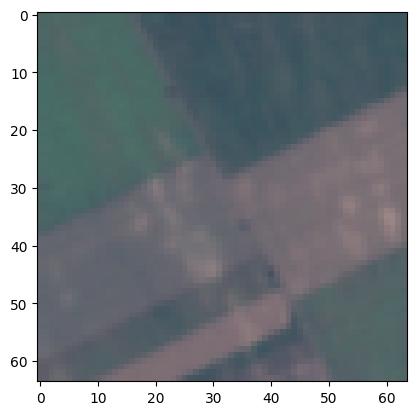

In [ ]:
img_path = example_image[:-10] + "real_A.png"
img = plt.imread(os.path.expanduser(img_path))
plt.imshow(img)

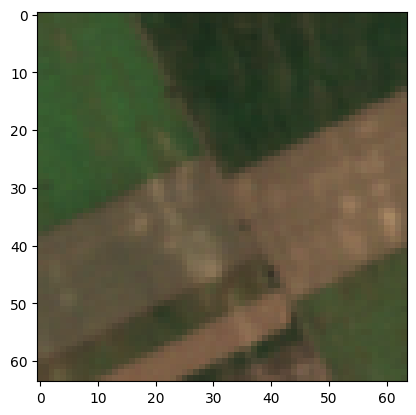

In [ ]:
img_path = example_image[:-10] + "fake_B.png"
img = plt.imread(os.path.expanduser(img_path))
plt.imshow(img)

## TRAIN

### Import packages and set random seeds.

In [6]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import random
import numpy as np
import torch
import pandas as pd

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # For multi-GPU setups
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


### Get training data

In [7]:
model_if_not_trained = 2

In [8]:
from sklearn.model_selection import train_test_split

if os.path.exists(os.path.expanduser("~/train_rft/pix2pix_MajTOM/test_latest/images/")):
  img_path = os.path.expanduser("~/train_rft/pix2pix_MajTOM/test_latest/images/")
elif os.path.exists(os.path.expanduser("~/train_rft/root/train_rft/pix2pix_MajTOM/test_latest/images/")):
  img_path = os.path.expanduser("~/train_rft/root/train_rft/pix2pix_MajTOM/test_latest/images/")
else:
  !cp models/Pix2Pix_Model_{model_if_not_trained}/train_rft.zip ~/train_rft.zip
  !unzip -q ~/train_rft.zip -d ~/train_rft
  !rm -rf ~/train_rft.zip
  img_path = os.path.expanduser("~/train_rft/root/train_rft/pix2pix_MajTOM/test_latest/images/")

df = pd.DataFrame(os.listdir(img_path))
df = df[df[0].str.contains("fake_B")]

df["label"] = df[0].apply(lambda x: x.split("_")[0])
df["full_path"] = df[0].apply(lambda x: os.path.join(img_path, x))

X = df["full_path"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class EuroSATDataset(Dataset):
    def __init__(self, data_paths, labels, transform=None, mode="train"):
        self.data_paths = data_paths
        self.labels = labels.apply(lambda x: class_to_idx[x]) if mode == "train" else labels
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        img_path = self.data_paths[idx]

        if self.mode == "train":
          image = cv2.imread(img_path)
          # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        else:
          img = np.load(img_path)
          bands = img[:, :, [1, 2, 3]]
          image = np.interp(bands, (0, 2750), (0, 255)).astype(np.uint8)

        if self.transform:
            image = self.transform(image)

        if self.mode == "train":
            label = self.labels[idx]
            return image, label
        else:
            id = int(img_path.split("_")[-1].split(".")[0])
            return image, id

# Define any transformations you want to apply to each image here
"""
Converts a  numpy.ndarray (H x W x C) to a torch.FloatTensor of shape (C x H x W)
  * if the numpy.ndarray has dtype = np.uint8 (OUR CASE) --> scaled to range [0.0, 1.0]
  * in other cases, tensors are returned without scaling.
"""
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])
transform_val = transforms.Compose([
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.ToTensor()
])

# All classes
all_class_names = ['HerbaceousVegetation', 'Highway', 'Forest', 'SeaLake', 'PermanentCrop', 'River', 'Pasture', 'Industrial', 'AnnualCrop', 'Residential']
class_to_idx = {class_name: idx for idx, class_name in enumerate(all_class_names)}

# Create datasets & loaders
train_dataset = EuroSATDataset(X_train, y_train, transform=transform_train, mode="train")
test_dataset = EuroSATDataset(X_test, y_test, transform=transform_val, mode="train")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

### Train model

In [11]:
resnet_name_suffix = "2C"

In [12]:
from torchvision import models
from torchvision.models import ResNet152_Weights
import cv2

model = models.resnet152(weights=ResNet152_Weights.DEFAULT)
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 90.4MB/s]


In [13]:
# Checkpointing and Early Stopping setup
num_epochs = 10
best_test_loss = float('inf')
patience_counter = 0
patience = 10  # How many epochs to wait after last time validation loss improved.
file_path = f"./models/resnet152_{resnet_name_suffix}.pt"

for epoch in range(num_epochs):
    # train
    model.train()
    train_losses = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        optimizer.zero_grad() # same as model.zero_grad if all params in optimizer
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)

    # validate
    model.eval()
    test_losses = []
    total_correct = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()
    test_loss = np.mean(test_losses)
    test_accuracy = total_correct / len(test_dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # checkpoint --> WHAT SHOULD I USE FOR CHECKPOINT? WHAT FOR EARLY STOP? TEST ACCURACY OR LOSS!
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), file_path)
        patience_counter = 0  # Reset counter if test loss improves
        print(f"Test loss improved to {test_loss:.4f}. Model saved.")
    else:
        patience_counter += 1
        print(f"Test loss did not improve. Patience counter: {patience_counter}")

    # early stopping
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/10, Train Loss: 1.0314, Test Loss: 0.6100, Test Accuracy: 0.7919
Test loss improved to 0.6100. Model saved.
Epoch 2/10, Train Loss: 0.5841, Test Loss: 0.5159, Test Accuracy: 0.8156
Test loss improved to 0.5159. Model saved.
Epoch 3/10, Train Loss: 0.4487, Test Loss: 0.4292, Test Accuracy: 0.8591
Test loss improved to 0.4292. Model saved.
Epoch 4/10, Train Loss: 0.3599, Test Loss: 0.4471, Test Accuracy: 0.8487
Test loss did not improve. Patience counter: 1
Epoch 5/10, Train Loss: 0.3071, Test Loss: 0.3084, Test Accuracy: 0.8944
Test loss improved to 0.3084. Model saved.
Epoch 6/10, Train Loss: 0.2598, Test Loss: 0.2427, Test Accuracy: 0.9150
Test loss improved to 0.2427. Model saved.
Epoch 7/10, Train Loss: 0.2285, Test Loss: 0.2239, Test Accuracy: 0.9202
Test loss improved to 0.2239. Model saved.
Epoch 8/10, Train Loss: 0.2013, Test Loss: 0.1992, Test Accuracy: 0.9306
Test loss improved to 0.1992. Model saved.
Epoch 9/10, Train Loss: 0.1898, Test Loss: 0.1914, Test Accuracy: 0.

## TEST

In [16]:
prediction_dir = os.path.expanduser("~/testset/testset")

pred_paths = [(int(x.split("_")[-1].split(".")[0]), x) for x in os.listdir(prediction_dir)]
df = pd.DataFrame(pred_paths, columns=["i", "path"])
df_sorted = df.sort_values(by="i")
prediction_paths = df_sorted["path"]
prediction_paths = prediction_paths.apply(lambda x: os.path.join(prediction_dir, x)).reset_index(drop=True)

prediction_dataset = EuroSATDataset(prediction_paths, None, transform=transform_test, mode="predict")
prediction_loader = DataLoader(prediction_dataset, batch_size=32, shuffle=False, num_workers=4)

In [17]:
predictions = []
image_ids = []
# Load the best saved model's weights
model.load_state_dict(torch.load(file_path))
model.eval()
with torch.no_grad():
    for inputs, ids in prediction_loader:
        inputs, ids = inputs.to(device), ids.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_classes = [all_class_names[idx] for idx in predicted.cpu().numpy()]
        predictions.extend(predicted_classes)
        image_ids.extend(ids.cpu().tolist())

prediction_results = list(zip(image_ids, predictions))
df = pd.DataFrame(prediction_results, columns=["test_id", "label"])
df_sorted = df.sort_values(by="test_id")
df_sorted.to_csv(f"model_{resnet_name_suffix}.csv", index=False)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
